In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

from duped_modules.dcn_duped import DCNDuped
from duped_modules.dec_duped import DECDuped, IDECDuped
from duped_modules.embeddings_autoencoder import EmbeddingsAutoencoder

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,-0.056962,-0.961440,1,0,12,7,-0.295171,1,1,-0.302596,0,0,0.128682,-0.193125
1,0,2.296536,-0.073565,1,0,10,3,0.236217,1,1,0.704516,0,0,-0.816802,-0.086443
2,0,-0.592078,-0.861903,1,0,10,3,-0.220955,1,0,-0.504019,0,0,0.592504,-0.036150
3,1,-0.310572,-0.654865,1,0,12,7,0.446990,1,1,0.503093,1,0,-0.477855,-0.192553
4,1,-0.958122,0.158358,1,0,12,7,-0.158613,1,0,-0.504019,0,2,-0.358926,-0.193125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,-0.881193,1.046233,2,2,4,3,-0.295171,0,0,-0.504019,0,0,0.473575,-0.193125
686,0,-0.746780,-0.812134,1,0,1,7,-0.072523,0,1,-0.101174,1,0,0.116789,-0.118066
687,0,-0.528676,1.726075,2,2,5,2,-0.072523,0,1,-0.302596,1,0,0.116789,-0.192934
688,1,-1.148329,-0.920630,1,0,0,7,-0.654378,0,0,-0.504019,0,0,0.592504,-0.050247


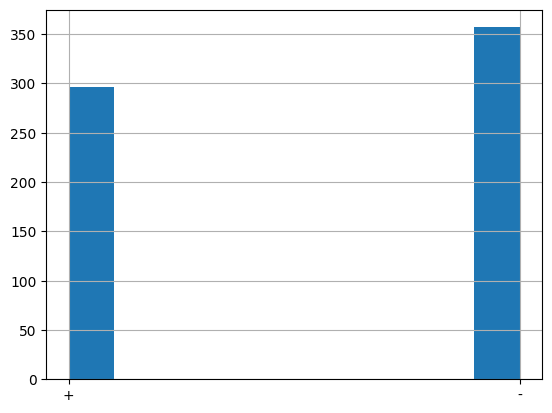

In [2]:
credit_df = pd.read_csv("datasets/credit_approval.csv")
credit_df.replace("?", pd.NA, inplace=True)
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

credit_y = credit_df["A16"]
credit_y.hist()
credit_y = LabelEncoder().fit_transform(credit_y)

credit_cat_cols = ["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
credit_cont_cols = ["A2", "A3", "A8", "A11", "A14", "A15"]

credit_df.drop(columns="A16", inplace=True)
credit_df[credit_cat_cols] = credit_df[credit_cat_cols].apply(LabelEncoder().fit_transform)
credit_df[credit_cont_cols] = StandardScaler().fit_transform(credit_df[credit_cont_cols])
credit_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0.940446,1,3,0.749760,-0.262867,1,0,0.029124,0,1.069475,0,-0.718306,0
1,1.384143,1,0,1.596354,0.747722,0,0,-1.790447,1,0.380309,1,2.487269,1
2,1.384143,1,0,-0.661231,-0.339138,0,0,-0.880662,1,1.327912,1,1.418744,2
3,-1.943588,1,2,-0.096835,0.061285,0,1,1.632079,0,2.103224,0,-0.718306,1
4,-1.499891,0,1,-0.096835,-0.815830,0,0,0.982232,0,0.294163,2,-0.718306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,1.495068,1,0,0.693320,-1.025575,1,1,-0.360784,0,2.017078,1,1.418744,2
300,0.274900,1,0,-0.096835,-2.207774,0,1,-1.487186,1,0.121872,1,0.350219,2
301,0.274900,0,1,-0.096835,-0.205664,0,0,1.068878,0,-0.911877,1,0.350219,1
508,-0.834344,1,0,1.031958,-0.396341,0,1,-2.223678,1,0.380309,1,-0.718306,2


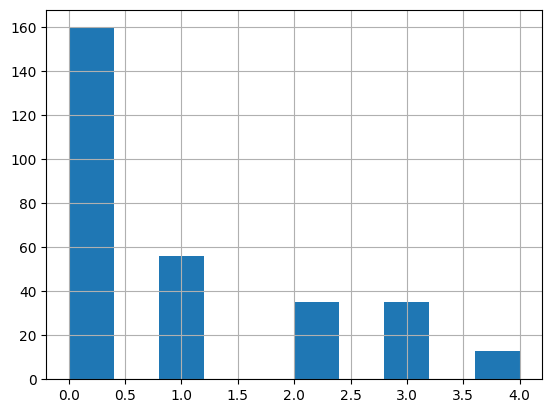

In [3]:
heart_df = pd.read_csv("datasets/heart_disease.csv")
heart_df.dropna(inplace=True)
heart_df.drop_duplicates(inplace=True)

heart_df["num"].hist()
heart_y = heart_df["num"].to_numpy()

heart_cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
heart_cont_cols = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

heart_df.drop(columns=["id", "dataset", "num"], inplace=True)
heart_df.dropna(inplace=True)

heart_df[heart_cat_cols] = heart_df[heart_cat_cols].apply(LabelEncoder().fit_transform)
heart_df[heart_cont_cols] = StandardScaler().fit_transform(heart_df[heart_cont_cols])
heart_df

In [4]:
class CreditDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[credit_cat_cols].values, dtype=torch.int)
        self.cont = torch.tensor(df[credit_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

credit_dataloader = DataLoader(CreditDataset(credit_df), batch_size=32, shuffle=True)

credit_emb_sizes = [(credit_df[col].nunique(), min(50, credit_df[col].nunique() + 1) // 2) for col in credit_df[credit_cat_cols]]
credit_cat_dim = sum(d for _, d in credit_emb_sizes)
credit_cont_dim = len(credit_cont_cols)
credit_input_dim = credit_cat_dim + credit_cont_dim

print(f"Cat dim: {credit_cat_dim}, Input dim: {credit_input_dim}")
print(f"Embeddings: {credit_emb_sizes}")

Cat dim: 22, Input dim: 28
Embeddings: [(2, 1), (3, 2), (3, 2), (14, 7), (9, 5), (2, 1), (2, 1), (2, 1), (3, 2)]


In [5]:
class HeartDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[heart_cat_cols].values, dtype=torch.int)
        self.cont = torch.tensor(df[heart_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

heart_dataloader = DataLoader(HeartDataset(heart_df), batch_size=16, shuffle=True)

heart_emb_sizes = [(heart_df[col].nunique(), min(50, heart_df[col].nunique() + 1) // 2) for col in heart_df[heart_cat_cols]]
heart_cat_dim = sum(d for n, d in heart_emb_sizes)
heart_cont_dim = len(heart_cont_cols)
heart_input_dim = heart_cat_dim + heart_cont_dim

print(f"Cat dim: {heart_cat_dim}, Input dim: {heart_input_dim}")
print(f"Embeddings: {heart_emb_sizes}")

Cat dim: 11, Input dim: 17
Embeddings: [(2, 1), (4, 2), (2, 1), (3, 2), (2, 1), (3, 2), (3, 2)]


In [6]:
# Cat dim: 22, Input dim: 28
# credit_cat_encoder = nn.Sequential(
#     nn.Linear(credit_cat_dim, 18),
#     nn.BatchNorm1d(18),
#     nn.ReLU(),
#     nn.Linear(18, 10),
#     nn.BatchNorm1d(10),
#     nn.ReLU(),
#     nn.Linear(10, 6),
#     nn.BatchNorm1d(6),
#     nn.ReLU(),
# )
# credit_cont_encoder = nn.Sequential(
#     nn.Linear(credit_cont_dim, 5),
#     nn.BatchNorm1d(5),
#     nn.ReLU(),
#     nn.Linear(5, 4),
#     nn.BatchNorm1d(4),
#     nn.ReLU(),
# )
credit_encoder = torch.nn.Sequential(
    torch.nn.Linear(credit_input_dim, 20),
    torch.nn.BatchNorm1d(20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 14),
    torch.nn.BatchNorm1d(14),
    torch.nn.Sigmoid(),
    torch.nn.Linear(14, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.Sigmoid(),
)
credit_decoder = nn.Sequential(
    nn.Linear(8, 14),
    nn.ReLU(),
    nn.Linear(14, 20),
    nn.ReLU(),
    nn.Linear(20, credit_input_dim),
    nn.ReLU()
)
credit_ae = EmbeddingsAutoencoder(deepcopy(credit_encoder), deepcopy(credit_decoder), credit_input_dim, credit_cat_dim, credit_emb_sizes, attention=False)
credit_ae.fit(n_epochs=100, lr=0.001, dataloader=credit_dataloader)

credit_attention_ae = EmbeddingsAutoencoder(deepcopy(credit_encoder), deepcopy(credit_decoder), credit_input_dim, credit_cat_dim, credit_emb_sizes, attention=True)
credit_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=credit_dataloader)

cat = torch.tensor(credit_df[credit_cat_cols].values, dtype=torch.int)
cont = torch.tensor(credit_df[credit_cont_cols].values, dtype=torch.float)
cat_features = credit_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, credit_df[credit_cont_cols].values), 1)
credit_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
credit_ae_nmi = normalized_mutual_info_score(credit_y, credit_ae_kmeans.labels_)
print(credit_ae_nmi)

cat = torch.tensor(credit_df[credit_cat_cols].values, dtype=torch.int)
cont = torch.tensor(credit_df[credit_cont_cols].values, dtype=torch.float)
cat_features = credit_attention_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, credit_df[credit_cont_cols].values), 1)
credit_attention_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
credit_attention_ae_nmi = normalized_mutual_info_score(credit_y, credit_attention_ae_kmeans.labels_)
print(credit_attention_ae_nmi)

Epoch 25/100 - Batch Reconstruction loss: 0.576437
Epoch 50/100 - Batch Reconstruction loss: 0.602047
Epoch 75/100 - Batch Reconstruction loss: 0.540391
Epoch 100/100 - Batch Reconstruction loss: 0.533555
Epoch 25/100 - Batch Reconstruction loss: 0.692244
Epoch 50/100 - Batch Reconstruction loss: 0.669816
Epoch 75/100 - Batch Reconstruction loss: 0.593816
Epoch 100/100 - Batch Reconstruction loss: 0.523216
0.08584599468164314
0.07883828809409929


In [7]:
# Cat dim: 11, Input dim: 17
# heart_cat_encoder = nn.Sequential(
#     nn.Linear(heart_cat_dim, 7),
#     nn.BatchNorm1d(7),
#     nn.ReLU(),
#     nn.Linear(7, 4),
#     nn.BatchNorm1d(4),
#     nn.ReLU(),
# )
# heart_cont_encoder = nn.Sequential(
#     nn.Linear(heart_cont_dim, 5),
#     nn.BatchNorm1d(5),
#     nn.ReLU(),
#     nn.Linear(5, 4),
#     nn.BatchNorm1d(4),
#     nn.ReLU(),
# )
heart_encoder = torch.nn.Sequential(
    torch.nn.Linear(heart_input_dim, 13),
    torch.nn.BatchNorm1d(13),
    torch.nn.ReLU(),
    torch.nn.Linear(13, 9),
    torch.nn.BatchNorm1d(9),
    torch.nn.Sigmoid(),
    torch.nn.Linear(9, 6),
    torch.nn.BatchNorm1d(6),
    torch.nn.Sigmoid(),
)
heart_decoder = nn.Sequential(
    nn.Linear(6, 9),
    nn.ReLU(),
    nn.Linear(9, 13),
    nn.ReLU(),
    nn.Linear(13, heart_input_dim),
    nn.ReLU()
)
heart_ae = EmbeddingsAutoencoder(deepcopy(heart_encoder), deepcopy(heart_decoder), heart_input_dim, heart_cat_dim, heart_emb_sizes, attention=False)
heart_ae.fit(n_epochs=100, lr=0.001, dataloader=heart_dataloader)

heart_attention_ae = EmbeddingsAutoencoder(deepcopy(heart_encoder), deepcopy(heart_decoder), heart_input_dim, heart_cat_dim, heart_emb_sizes, attention=True)
heart_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=heart_dataloader)

cat = torch.tensor(heart_df[heart_cat_cols].values, dtype=torch.int)
cont = torch.tensor(heart_df[heart_cont_cols].values, dtype=torch.float)
cat_features = heart_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, heart_df[heart_cont_cols].values), 1)
heart_ae_kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0).fit(features)
heart_ae_nmi = normalized_mutual_info_score(heart_y, heart_ae_kmeans.labels_)
print(heart_ae_nmi)

cat = torch.tensor(heart_df[heart_cat_cols].values, dtype=torch.int)
cont = torch.tensor(heart_df[heart_cont_cols].values, dtype=torch.float)
cat_features = heart_attention_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, heart_df[heart_cont_cols].values), 1)
heart_attention_ae_kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0).fit(features)
heart_attention_ae_nmi = normalized_mutual_info_score(heart_y, heart_attention_ae_kmeans.labels_)
print(heart_attention_ae_nmi)

Epoch 25/100 - Batch Reconstruction loss: 0.987267
Epoch 50/100 - Batch Reconstruction loss: 0.747781
Epoch 75/100 - Batch Reconstruction loss: 0.816373
Epoch 100/100 - Batch Reconstruction loss: 0.797824
Epoch 25/100 - Batch Reconstruction loss: 0.695475
Epoch 50/100 - Batch Reconstruction loss: 0.761902
Epoch 75/100 - Batch Reconstruction loss: 0.757677
Epoch 100/100 - Batch Reconstruction loss: 0.690426
0.15541706672119207
0.138790976672472


In [8]:
credit_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_dcn.fit(credit_dataloader)
credit_dcn_nmi = normalized_mutual_info_score(credit_y, credit_dcn.labels_)
print(credit_dcn_nmi)

credit_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_dcn.fit(credit_dataloader)
credit_attention_dcn_nmi = normalized_mutual_info_score(credit_y, credit_attention_dcn.labels_)
print(credit_attention_dcn_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.0010289046130760638
0.0035725157072828842


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
heart_dcn = DCNDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_dcn.fit(heart_dataloader)
heart_dcn_nmi = normalized_mutual_info_score(heart_y, heart_dcn.labels_)
print(heart_dcn_nmi)

heart_attention_dcn = DCNDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_dcn.fit(heart_dataloader)
heart_attention_dcn_nmi = normalized_mutual_info_score(heart_y, heart_attention_dcn.labels_)
print(heart_attention_dcn_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.04463190171244836
0.024457733325903695


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
credit_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_dec.fit(credit_dataloader)
credit_dec_nmi = normalized_mutual_info_score(credit_y, credit_dec.labels_)
print(credit_dec_nmi)

credit_attention_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_dec.fit(credit_dataloader)
credit_attention_dec_nmi = normalized_mutual_info_score(credit_y, credit_attention_dec.labels_)
print(credit_attention_dec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.00044816304963971954
0.0007509657068353008


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
heart_dec = DECDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_dec.fit(heart_dataloader)
heart_dec_nmi = normalized_mutual_info_score(heart_y, heart_dec.labels_)
print(heart_dec_nmi)

heart_attention_dec = DECDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_dec.fit(heart_dataloader)
heart_attention_dec_nmi = normalized_mutual_info_score(heart_y, heart_attention_dec.labels_)
print(heart_attention_dec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.015326658800477885
0.02336400220745042


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
credit_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_idec.fit(credit_dataloader)
credit_idec_nmi = normalized_mutual_info_score(credit_y, credit_idec.labels_)
print(credit_idec_nmi)

credit_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_idec.fit(credit_dataloader)
credit_attention_idec_nmi = normalized_mutual_info_score(credit_y, credit_attention_idec.labels_)
print(credit_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.00022213321091800602
0.0017572320790356325


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
heart_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_idec.fit(heart_dataloader)
heart_idec_nmi = normalized_mutual_info_score(heart_y, heart_idec.labels_)
print(heart_idec_nmi)

heart_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_idec.fit(heart_dataloader)
heart_attention_idec_nmi = normalized_mutual_info_score(heart_y, heart_attention_idec.labels_)
print(heart_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.010213086317213675
0.013596745716791996


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
